# Deep Learning: CNN with ASL dataset
> AHSNCCU/NTNU CSIE 王修佑

Convolution Neural Network 卷積神經網路

## 載入和準備資料

> Colab要先 `!git clone https://github.com/whyhugo/CV-handouts.git`  
> 檔案位置修改為 `"/content/CV-handouts/asl/FileName"`

In [1]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("asl/sign_mnist_train.csv")
valid_df = pd.read_csv("asl/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

## 為卷積神經網路重新調整影像

+ 將目前的形狀(784像素) `(27455, 784)`轉換成(28x28像素) `(27455, 28, 28, 1)`
+ reshape(`-1`不改變維度, `28`像素, `28`像素, `1`色頻數量)

In [2]:
x_train.shape, x_valid.shape

((27455, 784), (7172, 784))

In [3]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [4]:
x_train.shape

(27455, 28, 28, 1)

In [5]:
x_valid.shape

(7172, 28, 28, 1)

In [6]:
x_train.shape, x_valid.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

## 建立卷積模型

<img src="images/cnn.png" width=180 />

解決類似的問題，可使用開源模型修改

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

### Conv2D

<img src="images/conv2d.png" width=300 />

2D 卷積層
```Python
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same'...)
```
75 指的是將要學習的核心(過濾器filter)數量。(3,3) 指的是這些核心的大小。strides指的是濾鏡經過影像時採用的步長。padding指的是從濾鏡建立的輸出影像是否與輸入影像的大小相符(convolution 會縮小)。

<img src="images/filter.gif" width=600 />

> ☝️這就是權重共享

> Feature Map Size: Output = (Input+2Padding-FilterSize)/Stride+1 = Input

### BatchNormalization

批次正規化
> 調整隱藏層中的值，以提升訓練品質<br>
+ 有效減緩Activation Function(Sigmoid) 梯度(Gradient)消失的問題
+ 解決 Internal Covariate Shift
+ 加速模型收斂
+ 具有正則化效果

> Reference: https://medium.com/ching-i/batch-normalization-%E4%BB%8B%E7%B4%B9-135a24928f12

### MaxPool2D

池化方式比較

<img src="images/池化方式比較.png" width=350 />

+ 藉由對資料subsampling，減少計算成本
+ 同時可保有特徵不變性
+ 總結來講，提高Receptive Field

### Dropout

+ 預防Overfitting
+ 原理：隨機選取並關閉神經元的子集，所以這些神經元不會在特定階段中參與正向或反向傳播。這有助於確保網路的泛化和降低冗餘神經元發生機率，且不依賴任何單一區域來產生答案。

### Flatten

為進入下一層FC做準備

### Dense

運用Activation Function分類！👉輸出預測結果

## 總結模型

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

## 編寫模型

In [9]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

## 訓練模型

In [10]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()
        
callbacks_list = [PlotLearning()]

#callbacks=callbacks_list

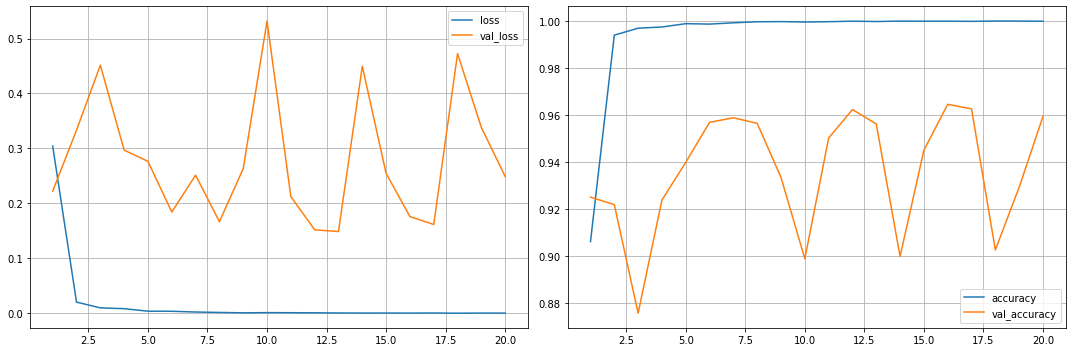

858/858 [==============================] - 36s 43ms/step - loss: 2.0720e-04 - accuracy: 0.9999 - val_loss: 0.2488 - val_accuracy: 0.9594


In [11]:
model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_valid, y_valid), callbacks=callbacks_list)

## 結果討論

訓練準確度與驗證準確度是否都提高了呢？  
model仍沒有完美泛化(Generalization)的能力？

## 清除記憶體

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)